# Compare annual timeseries between GIMMS-PKU consolidated, Landsat, MODIS, AVHRR-Adj.


In [1]:
import numpy as np
import xarray as xr
import seaborn as sb
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
import contextily as ctx
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from matplotlib.ticker import FormatStrFormatter

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

# Using ggplot styles in this notebook
plt.style.use('ggplot')

%matplotlib inline

## Analysis Parameters

In [2]:
model_var='NDVI'
crs='epsg:4326'
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

## Open datasets

In [3]:
syn = xr.open_dataset(f'{base}/synthetic/{model_var}/{model_var}_CLIM_synthetic_5km_monthly_1982_2022.nc')['NDVI']
syn = assign_crs(syn, crs=crs)
syn.attrs['nodata'] = np.nan
syn = syn.rename({model_var})

pku = xr.open_dataarray(f'{base}/{model_var}_harmonization/AVHRR_GIMMS-PKU-MODIS_1982_2022.nc')
pku = assign_crs(pku, crs=crs)
pku.attrs['nodata'] = np.nan

ls = xr.open_dataset(base+'/NDVI_harmonization/Landsat_NDVI_5km_monthly_1988_2012.nc')['NDVI']
ls = assign_crs(ls, crs=crs)
ls.attrs['nodata'] = np.nan

trees = xr.open_dataset(f'{base}NDVI_harmonization/LGBM/NDVI_trees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
nontrees = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_nontrees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
desert = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_desert_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
merge = xr.where(np.isnan(trees), nontrees, trees)
merge = xr.where(np.isnan(desert), merge, desert)

#gapfill
obs_monthly = merge.groupby('time.month').mean()
obs_anom = merge.groupby('time.month') - obs_monthly
obs_anom = obs_anom.interpolate_na(dim='time', method='linear', limit=1)
merge = obs_anom.groupby('time.month') + obs_monthly
merge = assign_crs(merge.drop('month'), crs='epsg:4326')
merge = merge.fillna(syn.sel(time=slice('1982','2013')))
merge.attrs['nodata'] = np.nan
merge = assign_crs(merge, crs=crs)
merge = merge.rename('NDVI')

rain = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_5km_monthly_1981_2022.nc').rain
rain = assign_crs(rain, crs=crs)
rain.attrs['nodata'] = np.nan

## Match datasets

In [4]:
pku = pku.sel(time=ls.time)
merge = merge.sel(time=ls.time)
rain = rain.sel(time=ls.time)
syn = syn.sel(time=ls.time)

merge = merge.odc.reproject(pku.odc.geobox, resampling='average')
ls = ls.odc.reproject(pku.odc.geobox, resampling='average')
rain = rain.odc.reproject(pku.odc.geobox, resampling='average')
syn = syn.odc.reproject(pku.odc.geobox, resampling='average')

merge = round_coords(merge)
ls = round_coords(ls)
pku = round_coords(pku)
rain = round_coords(rain)
syn = round_coords(syn)

In [5]:
#gapfill PKU in the same way as our product
obs_monthly = pku.groupby('time.month').mean()
obs_anom = pku.groupby('time.month') - obs_monthly
obs_anom = obs_anom.interpolate_na(dim='time', method='linear', limit=1)
pku = obs_anom.groupby('time.month') + obs_monthly
pku = pku.drop('month')
pku = pku.fillna(syn)

#create nodata masks
avhrr_mask =  ~np.isnan(merge)
pku_mask =  ~np.isnan(pku)
ls_mask =  ~np.isnan(ls)

#combine masks
mask = (avhrr_mask & pku_mask & ls_mask) # & cdr_mask

In [6]:
pku = pku.where(mask)
merge = merge.where(mask)
rain = rain.where(mask)
syn = syn.where(mask)
ls = ls.where(mask)

merge = merge.rename({'latitude':'y', 'longitude':'x'})
pku = pku.rename({'latitude':'y', 'longitude':'x'})
ls = ls.rename({'latitude':'y', 'longitude':'x'})
rain = rain.rename({'latitude':'y', 'longitude':'x'})
syn = syn.rename({'latitude':'y', 'longitude':'x'})

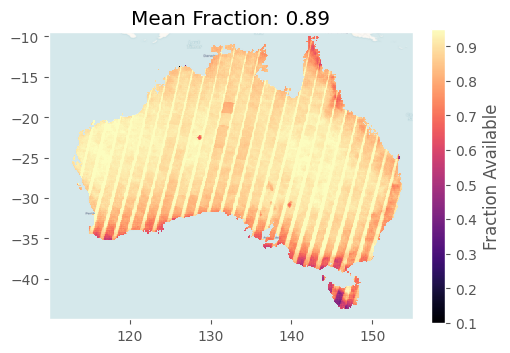

In [7]:
fraction_avail= (~np.isnan(pku)).sum('time')/len(pku.time)

fig,ax=plt.subplots(1,1, figsize=(5,4),sharey=True, layout='constrained')

im = fraction_avail.where(fraction_avail>0).rename('').plot(vmin=0.1, vmax=0.95, ax=ax, cmap='magma', add_labels=False, add_colorbar=False)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)

cb = fig.colorbar(im, ax=ax, shrink=0.75, orientation='vertical', label='Fraction Available');
ax.set_title('Mean Fraction: '+str(round(fraction_avail.where(fraction_avail>0).mean().values.item(), 3)));

## Calculate standardised anomalies

In [8]:
import warnings
warnings.simplefilter('ignore')

#standardized anom
def stand_anomalies(ds):
    return xr.apply_ufunc(
        lambda x, m, s: (x - m) / s,
            ds.groupby("time.month"),
            ds.groupby("time.month").mean(),
            ds.groupby("time.month").std()
    )
    
rain_std_anom = stand_anomalies(rain)
pku_std_anom = stand_anomalies(pku)
merge_std_anom = stand_anomalies(merge)
ls_std_anom = stand_anomalies(ls)
syn_std_anom = stand_anomalies(syn)

## Rolling mean anomalies

In [9]:
roll=12

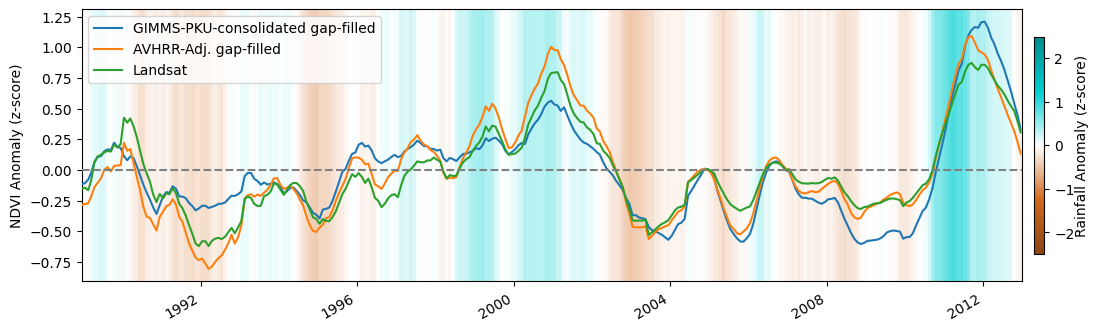

In [10]:
rain_df = rain_std_anom.rename('rain').rolling(time=roll,
                min_periods=roll).mean().mean(['x','y']).sel(time=slice('1989', '2013')).to_dataframe().drop(['spatial_ref', 'month'], axis=1)

plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(14,4))
ax2 = ax.twinx()

pku_std_anom.drop('month').rolling(time=roll, min_periods=roll).mean().mean(['x','y']).plot(ax=ax, label='GIMMS-PKU-consolidated gap-filled')
merge_std_anom.drop('month').rolling(time=roll, min_periods=roll).mean().mean(['x','y']).plot(ax=ax, label='AVHRR-Adj. gap-filled')
# syn_std_anom.drop('month').mean(['x','y']).rolling(time=roll, min_periods=roll).mean().plot(ax=ax, label='Synthetic')
ls_std_anom.drop('month').rolling(time=roll, min_periods=roll).mean().mean(['x','y']).plot(ax=ax, label='Landsat')

norm=plt.Normalize(-2.5,2.5)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['saddlebrown','chocolate','white','darkturquoise','darkcyan'], N=256)

# Plot bars
bar = ax2.bar(rain_df.index, 1, color=cmap(norm(rain_df['rain'])), width=32)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.8, pad=0.01)
cbar.set_label('Rainfall Anomaly (z-score)',labelpad=.5)

ax2.set_zorder(ax.get_zorder()-1)
ax.set_frame_on(False)
ax.axhline(0, c='grey', linestyle='--')

# Reformat y-axis label and tick labels
ax.set_ylabel(model_var+' Anomaly (z-score)')
ax.set_xlabel('')
ax2.set_ylabel('')
ax2.set_yticks([])
ax2.set_ylim([0, 1]) 
ax.margins(x=0)
ax2.margins(x=0)

# Adjust the margins around the plot area
plt.subplots_adjust(left=0.1, right=None, top=None, bottom=0.2, wspace=None, hspace=None)

ax.legend()
ax.set_title(None);
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/Australian_NDVI_compare_PKU_landsat_anomalies_"+str(roll)+"Mrollingmean.png",
            bbox_inches='tight', dpi=300)

## Create a Aus-wide timeseries plot, NOT anomalies

With rainfall anomalies

In [11]:
pku = xr.open_dataarray(f'{base}/{model_var}_harmonization/AVHRR_GIMMS-PKU-MODIS_1982_2022.nc')
pku = pku.sel(time=slice('1982', '2013'))
pku = assign_crs(pku, crs=crs)
pku.attrs['nodata'] = np.nan

#because modis is joined we can just load the final dataset
modis = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_noGaps.nc')['NDVI']
modis = modis.sel(time=slice('2000-02', '2013'))
modis = assign_crs(modis, crs=crs)
modis.attrs['nodata'] = np.nan
modis = modis.rename('NDVI')

trees = xr.open_dataset(f'{base}NDVI_harmonization/LGBM/NDVI_trees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
nontrees = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_nontrees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
desert = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_desert_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
merge = xr.where(np.isnan(trees), nontrees, trees)
merge = xr.where(np.isnan(desert), merge, desert)

syn = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/synthetic/NDVI/NDVI_CLIM_synthetic_5km_monthly_1982_2022.nc')['NDVI']
obs_monthly = merge.groupby('time.month').mean()
obs_anom = merge.groupby('time.month') - obs_monthly
obs_anom = obs_anom.interpolate_na(dim='time', method='linear', limit=1)
merge = obs_anom.groupby('time.month') + obs_monthly
merge = assign_crs(merge.drop('month'), crs='epsg:4326')
merge = merge.fillna(syn.sel(time=slice('1982','2013')))
merge = assign_crs(merge, crs=crs)
merge.attrs['nodata'] = np.nan
merge = merge.rename('NDVI')

rain = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_5km_monthly_1981_2022.nc').rain
rain = assign_crs(rain, crs=crs)
rain.attrs['nodata'] = np.nan
rain = rain.sel(time=slice('1982', '2013'))

In [12]:
merge = merge.odc.reproject(pku.odc.geobox, resampling='average')
modis = modis.odc.reproject(pku.odc.geobox, resampling='average')
rain = rain.odc.reproject(pku.odc.geobox, resampling='average')
syn = syn.odc.reproject(pku.odc.geobox, resampling='average')

merge = round_coords(merge)
modis = round_coords(modis)
pku = round_coords(pku)
rain = round_coords(rain)
syn = round_coords(syn)

In [13]:
#gapfill PKU the same as our product
obs_monthly = pku.groupby('time.month').mean()
obs_anom = pku.groupby('time.month') - obs_monthly
obs_anom = obs_anom.interpolate_na(dim='time', method='linear', limit=1)
pku = obs_anom.groupby('time.month') + obs_monthly
pku = pku.drop('month')
pku = pku.fillna(syn.sel(time=slice('1982','2013')))

In [14]:
avhrr_mask =  ~np.isnan(merge)
pku_mask =  ~np.isnan(pku)

#combine masks
mask = (avhrr_mask & pku_mask) # & cdr_mask
# mask = np.isnan(pku.isel(time=1))

In [15]:
pku = pku.where(mask)
merge = merge.where(mask)
modis = modis.where(mask.sel(time=modis.sel(time=slice('2000','2013')).time))
# rain = rain.where(mask)

merge = merge.rename({'latitude':'y', 'longitude':'x'})
modis = modis.rename({'latitude':'y', 'longitude':'x'})
pku = pku.rename({'latitude':'y', 'longitude':'x'})
rain = rain.rename({'latitude':'y', 'longitude':'x'})


In [16]:
rain_clim_std = rain.groupby('time.month').std().compute()
rain_clim_mean = rain.groupby('time.month').mean().compute()

#standardized anom
def stand_anomalies(ds, clim_mean, clim_std):
    std_anom = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
    ds.compute().groupby("time.month"),
    clim_mean, clim_std)
    return std_anom

rain_std_anom = stand_anomalies(rain, rain_clim_mean, rain_clim_std)


In [17]:
roll=12

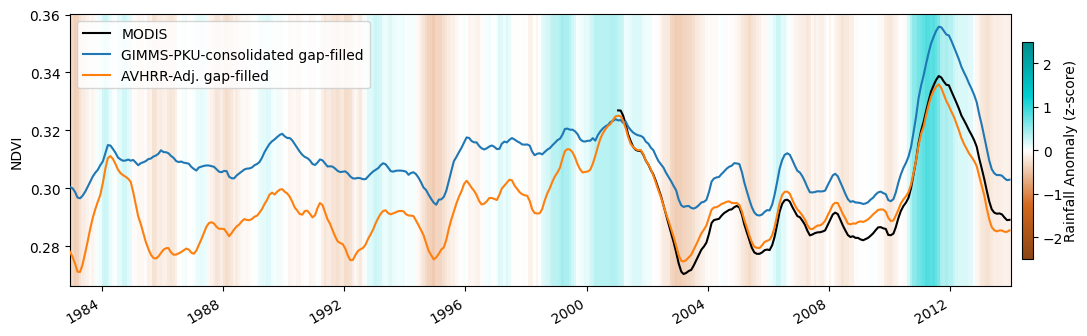

In [18]:

rain_df = rain_std_anom.rename('rain').mean(['x','y']).rolling(time=roll,
                min_periods=roll).mean().sel(time=slice('1983', '2013')).to_dataframe().drop(['spatial_ref', 'month'], axis=1)

plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(14,4))
ax2 = ax.twinx()
# .rolling(time=3, min_periods=1).mean()
modis.rolling(time=roll, min_periods=roll).mean().mean(['x','y']).plot(ax=ax, label='MODIS', c='black')
pku.rolling(time=roll, min_periods=roll).mean().mean(['x','y']).plot(ax=ax, label='GIMMS-PKU-consolidated gap-filled')
merge.rolling(time=roll, min_periods=roll).mean().mean(['x','y']).plot(ax=ax, label='AVHRR-Adj. gap-filled')


norm=plt.Normalize(-2.5,2.5)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['saddlebrown','chocolate','white','darkturquoise','darkcyan'], N=256)

# Plot bars
bar = ax2.bar(rain_df.index, 1, color=cmap(norm(rain_df['rain'])), width=32)

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.8, pad=0.01)
cbar.set_label('Rainfall Anomaly (z-score)',labelpad=.5)

ax2.set_zorder(ax.get_zorder()-1)
ax.set_frame_on(False)

# Reformat y-axis label and tick labels
ax.set_ylabel(model_var)
ax.set_xlabel('')
ax2.set_ylabel('')
ax2.set_yticks([])
ax2.set_ylim([0, 1]) 
ax.margins(x=0)
ax2.margins(x=0)

# Adjust the margins around the plot area
plt.subplots_adjust(left=0.1, right=None, top=None, bottom=0.2, wspace=None, hspace=None)

# if model_var=='NDVI':
#     # ax.set_ylim(0.20, 0.40)

ax.legend()
ax.set_title(None);
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/Australian_NDVI_compare_PKU_modis_"+str(roll)+"_rollingmean.png",
            bbox_inches='tight', dpi=300)

In [19]:
# fig, ax = plt.subplots(1,1, figsize=(14,4))
# pku = xr.open_dataarray(f'{base}/{model_var}_harmonization/AVHRR_GIMMS-PKU-MODIS_1982_2022.nc')
# pku.mean(['latitude','longitude']).rolling(time=12, min_periods=1).mean().plot(ax=ax)

# merge = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_noGaps.nc')['NDVI']
# merge.mean(['latitude','longitude']).rolling(time=12, min_periods=1).mean().plot(ax=ax)

### Compare rainfall anomalies with NDVI anomalies per pixel

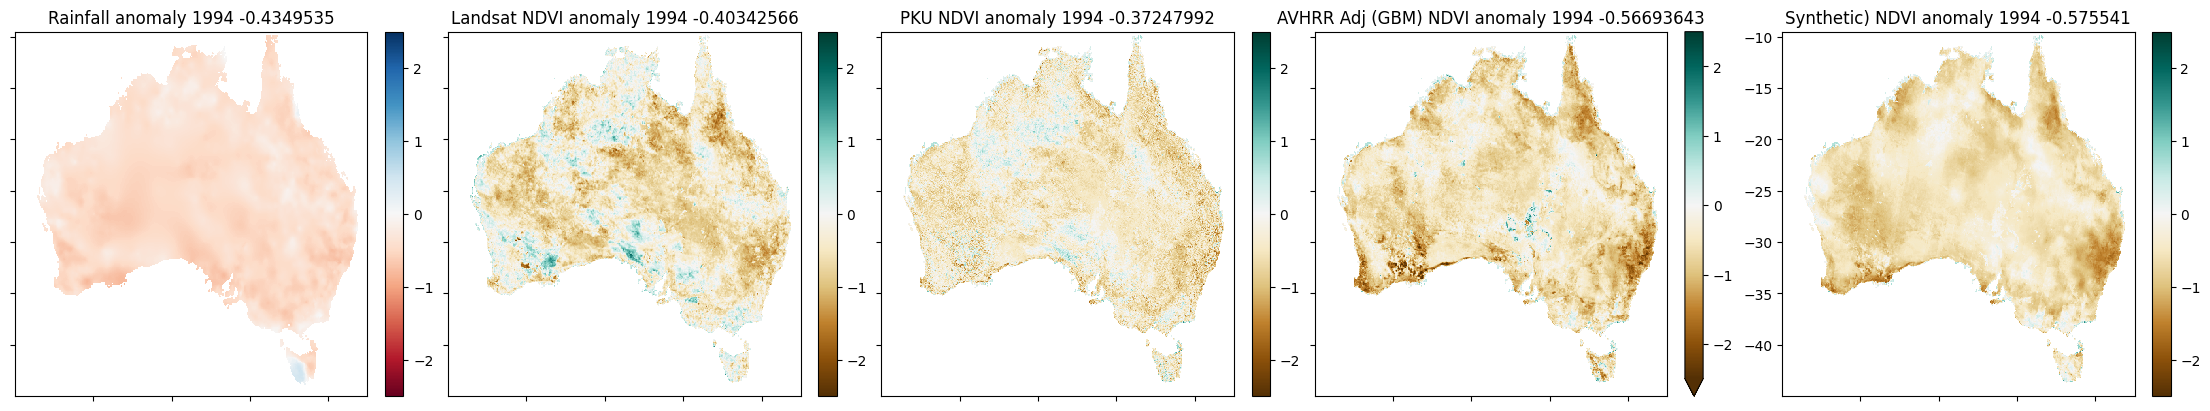

In [20]:
year='1994'

fig,ax = plt.subplots(1,5, figsize=(22,4), sharex=True, layout='constrained')
rain_std_anom.sel(time=year).mean('time').plot.imshow(vmin=-2.5, vmax=2.5, cmap='RdBu', ax=ax[0], add_labels=False)
ls_std_anom.sel(time=year).mean('time').plot.imshow(vmin=-2.5, vmax=2.5, cmap='BrBG', ax=ax[1], add_labels=False)
pku_std_anom.sel(time=year).mean('time').plot.imshow(vmin=-2.5, vmax=2.5, cmap='BrBG', ax=ax[2], add_labels=False)
merge_std_anom.sel(time=year).mean('time').plot.imshow(vmin=-2.5, vmax=2.5, cmap='BrBG', ax=ax[3], add_labels=False)
syn_std_anom.sel(time=year).mean('time').plot.imshow(vmin=-2.5, vmax=2.5, cmap='BrBG', ax=ax[4], add_labels=False)

ax[0].set_title('Rainfall anomaly '+year+' '+str(rain_std_anom.sel(time=year).mean().values))
ax[1].set_title('Landsat NDVI anomaly '+year+' '+str(ls_std_anom.sel(time=year).mean().values))
ax[2].set_title('PKU NDVI anomaly '+year+' '+str(pku_std_anom.sel(time=year).mean().values))
ax[3].set_title('AVHRR Adj (GBM) NDVI anomaly '+year+' '+str(merge_std_anom.sel(time=year).mean().values))
ax[4].set_title('Synthetic) NDVI anomaly '+year+' '+str(syn_std_anom.sel(time=year).mean().values))

ax[0].set_yticklabels([])
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_xticklabels([]);

ax[1].set_yticklabels([])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_xticklabels([]);

ax[2].set_yticklabels([])
ax[2].set_ylabel('')
ax[2].set_xlabel('')
ax[2].set_xticklabels([]);

ax[3].set_yticklabels([])
ax[3].set_ylabel('')
ax[3].set_xlabel('')
ax[3].set_xticklabels([]);